Set up
===

In [8]:
import pandas as pd
data_directory = '../data/'

In [9]:
time_series_metadata = pd.DataFrame(columns=['Units', 'Source'])
time_series_metadata.index.name='Name'

Bring in Farmer and Lafond data
===

In [10]:
df = pd.read_csv(data_directory+'original/Farmer_Lafond_Data.csv', index_col=0)

for col in df.columns:
    time_series_metadata.ix[col, 'Units'] = df[col].iloc[0]
    time_series_metadata.ix[col, 'Source'] = 'Farmer_Lafond'
    time_series_metadata.ix[col, 'Type'] = 'Price'


time_series = 1/df.iloc[2:].astype('float')

for col in df.columns:
    time_series_metadata.ix[col, 'n'] = time_series[col].notnull().sum()
    time_series_metadata.ix[col, 'Start'] = time_series[col].dropna().index[0]
    time_series_metadata.ix[col, 'Stop'] = time_series[col].dropna().index[-1]    

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Manual edits
----

In [11]:
time_series_metadata.ix['Automotive (US)', 'Type'] = 'Performance'
time_series_metadata.ix['Milk (US)', 'Type'] = 'Performance'

Bring in Magee et al data
===

In [12]:
from os import listdir
from numpy import sort
data_directories = sort(listdir(data_directory+'original/Magee_et_al_Data/'))

In [13]:
for d in data_directories:
    if d.startswith('.'):
        continue
    files = sort(listdir(data_directory+'original/Magee_et_al_Data/%s/'%d))
    for f in files:
        if f.endswith('.xlsx'):
            df = pd.read_excel(data_directory+'original/Magee_et_al_Data/%s/%s'%(d,f),sheetname='rawdata',index_col=0)
            col = f.split('_v1')[0].replace('.xlsx','')
            df = df[df.columns[0]]
            time_series_metadata.ix[col, 'Units'] = df.name
            time_series_metadata.ix[col, 'Source'] = 'Magee_et_al'
            time_series_metadata.ix[col, 'n'] = df.dropna().shape[0]
            time_series_metadata.ix[col, 'Start'] = df.dropna().index[0]
            time_series_metadata.ix[col, 'Stop'] = df.dropna().index[-1]
            df.name = col
            df.index = df.index.astype('float')
            df = df.groupby(level=0).max()
            units = time_series_metadata.ix[col, 'Units'].lower()
            if "cost" in units or "price" in units or "usd" in units or "$" in units or "dollar" in units:
                time_series_metadata.ix[col, 'Type'] = 'Price'
            else:
                time_series_metadata.ix[col, 'Type'] = 'Performance'
            time_series = time_series.join(df, how='outer')

Manual edits
----

In [14]:
time_series_metadata = time_series_metadata.rename(index={'AC_electricity_transmission_powered_distance_per_$_wkm_$':
                           'AC_electricity_transmission_powered_distance_per_cost_wkm_$'})

time_series = time_series.rename(columns={'AC_electricity_transmission_powered_distance_per_$_wkm_$':
                           'AC_electricity_transmission_powered_distance_per_cost_wkm_$'})

In [15]:
time_series_metadata.loc['electrical_info_transmission_kbps_per_$','Type'] = 'Price_Questionable'
time_series_metadata.loc['optical_telcom_bandwidth_kbps_per_$','Type'] = 'Price_Questionable'
time_series_metadata.loc['electronic_computation_mips_per_$','Type'] = 'Price_Questionable'
time_series_metadata.loc['MRI_mm_sec_$_resolution_cost','Type'] = 'Price_Questionable'
time_series_metadata.loc['AC_electricity_transmission_powered_distance_wkm','Type'] = 'Performance_Questionable'
time_series_metadata.loc['DC_electricity_transmission_powered_distance_wkm','Type'] = 'Performance_Questionable'
time_series_metadata.loc['Artificial_Illumination_LED_lumen_$','Type'] = 'Price_Questionable'
time_series_metadata.loc['Artificial_Illumination_LED_lumen_lamp','Type'] = 'Performance_Questionable'
time_series_metadata.loc['aeroplane_transport_pass_mile_hr','Type'] = 'Performance_Questionable'
time_series_metadata.loc['photolithography_arealthroughput_accuracy_cost','Type'] = 'Price_Questionable'

#And everything with 3D printing
for i in time_series_metadata.index:
    if '3D' in i:
        time_series_metadata.loc[i,'Type'] = time_series_metadata.loc[i,'Type']+'_Questionable'

Identify Domains
---

In [19]:
# patent_domains = pd.read_csv(data_directory+'PATENT_SET_DOMAINS.csv', index_col=0)

time_series_domains = pd.Series(index = time_series.columns)
time_series_domains['integrated_circuit_memory_transistors_per_die']='IC'
time_series_domains['integrated_circuit_memory_transistors_per_die']='IC'
time_series_domains['integrated_circuit_microprocessor_transistors_per_die']='IC'
time_series_domains['02A_magnetic_memory_tape_mbits_per_$']='MAGNETIC_INFO_STORAGE'
time_series_domains['02A_magnetic_memory_tape_mbits_per_cc']='MAGNETIC_INFO_STORAGE'
time_series_domains['02B_magnetic_memory_harddisk_mbits_per_$']='MAGNETIC_INFO_STORAGE'
time_series_domains['02B_magnetic_memory_harddisk_mbits_per_cc']='MAGNETIC_INFO_STORAGE'
time_series_domains['02C_magnetic_memory_tape_harddisk_mbits_per_$']='MAGNETIC_INFO_STORAGE'
time_series_domains['02C_magnetic_memory_tape_harddisk_mbits_per_cc']='MAGNETIC_INFO_STORAGE'
time_series_domains['optical_memory_per_$']='OPTICAL_INFO_STORAGE'
time_series_domains['optical_memory_per_cc']='OPTICAL_INFO_STORAGE'
time_series_domains['electrical_info_transmission_kbps_per_$']='ELECTRIC_TELECOM'
time_series_domains['electrical_info_transmission_kbps']='ELECTRIC_TELECOM'
time_series_domains['optical_telcom_bandwidth_kbps_per_$_km']='OPTICAL_TELECOM'
time_series_domains['optical_telecom_bandwidth_kbps']='OPTICAL_TELECOM'
time_series_domains['Wireless_Telecomunication_coverage_bps_per_m2']='WIRELESS_TELECOM'
time_series_domains['Wireless_Telecomunication_spectral_efficiency_bps_per_hz']='WIRELESS_TELECOM'
time_series_domains['Wireless_Telecomunication_throughput_kbps']='WIRELESS_TELECOM'
time_series_domains['computation_electronic_CPS']='ELECTRIC_COMPUTATION'
time_series_domains['electronic_computation_mips_per_$']='ELECTRIC_COMPUTATION'
time_series_domains['electronic_computation_mips']='ELECTRIC_COMPUTATION'
time_series_domains['camera_sensitivity_mv_micro_sqm']='CAMERA'
time_series_domains['MRI_mm_sec_$_resolution_cost']='MRI'
time_series_domains['MRI_mm_sec_resolution']='MRI'
time_series_domains['CTscan_mm_scantime_resolution']='CT'
time_series_domains['Genome_sequencing_base_pairs']='GENOME'
time_series_domains['batteries_wh_$']='BATTERIES'
time_series_domains['batteries_wh_kg_energy_density']='BATTERIES'
time_series_domains['batteries_wh_lit_energy_density']='BATTERIES'
time_series_domains['capacitors_kwhr_$']='CAPACITOR'
time_series_domains['capacitors_kwhr_kg']='CAPACITOR'
time_series_domains['capacitors_kwhr_lit']='CAPACITOR'
time_series_domains['Flywheel_kwh_kg']='FLYWHEEL'
time_series_domains['AC_electricity_transmission_powered_distance_per_cost_wkm_$']='ELECTRO_POWERTRANS'
time_series_domains['AC_electricity_transmission_powered_distance_wkm']='ELECTRO_POWERTRANS'
time_series_domains['DC_electricity_transmission_powered_distance_per_cost_wkm_$']='ELECTRO_POWERTRANS'
time_series_domains['DC_electricity_transmission_powered_distance_wkm']='ELECTRO_POWERTRANS'
time_series_domains['combustion_air_piston_engine_w_per_$']='COMB_ENGINE'
time_series_domains['combustion_air_piston_engine_w_per_kg']='COMB_ENGINE'
time_series_domains['combustion_air_piston_engine_w_per_lit']='COMB_ENGINE'
time_series_domains['combustion_air_turbine_engine_w_per_$']='COMB_ENGINE'
time_series_domains['combustion_air_turbine_engine_w_per_kg']='COMB_ENGINE'
time_series_domains['combustion_air_turbine_engine_w_per_lit']='COMB_ENGINE'
time_series_domains['combustion_pass_car_engine_w_per_$']='COMB_ENGINE'
time_series_domains['combustion_pass_car_engine_w_per_kg']='COMB_ENGINE'
time_series_domains['combustion_pass_car_piston_engine_w_per_lit']='COMB_ENGINE'
time_series_domains['electricmotor_w_per_kg_11.14.2013']='ELECTRIC_MOTOR'
time_series_domains['electricmotor_w_per_lit_11.14.2013']='ELECTRIC_MOTOR'
time_series_domains['solar_PV_Wpeak_$']='SOLAR_PV'
time_series_domains['solar_PV_kwh_module$2011']='SOLAR_PV'
time_series_domains['wind_turbine_W_$']='WIND'
time_series_domains['FuelCell_kW_$']='FUELCELL'
time_series_domains['Artificial_Illumination_Incandescent_1000lumenhrs_per_$']='INCANDESCENT'
time_series_domains['Artificial_Illumination_LED_lumen_$']='LED'
time_series_domains['Artificial_Illumination_LED_lumen_lamp']='LED'
time_series_domains['aeroplane_transport_pass_mile_hr']='AIRCRAFT'
time_series_domains['Milling_yearlyaverage_hp.accuracy']='MILLING'
time_series_domains['3dprintingSLA_speed_buildvolume_layerthickness_cost']='TRID_PRINTING'
time_series_domains['3dprintingSLA_speed_buildvolume_layerthickness_machinesize_cost']='TRID_PRINTING'
time_series_domains['3dprintingSLA_speed_layerthickness_cost']='TRID_PRINTING'
time_series_domains['3dprintingSLA_speed_layerthickness']='TRID_PRINTING'
time_series_domains['photolithography_arealthroughput_accuracy_cost']='PHOTOLITHOGRAPHY'
time_series_domains['photolithography_arealthroughput_accuracy']='PHOTOLITHOGRAPHY'
time_series_domains['photolithography_arealthroughput_cost']='PHOTOLITHOGRAPHY'
time_series_domains['superconductivity_critical_temperature']='SUPERCONDUCTOR'

#Unsure about all of these
time_series_domains['Automotive (US)'] = 'COMB_ENGINE'
time_series_domains['DNA Sequencing'] = 'GENOME'
time_series_domains['Hard Disk Drive'] = 'MAGNETIC_INFO_STORAGE'
time_series_domains['DRAM'] = 'MAGNETIC_INFO_STORAGE'
time_series_domains['DRAM'] = 'MAGNETIC_INFO_STORAGE'
time_series_domains['Transistor'] = 'ELECTRIC_COMPUTATION'
time_series_domains['Photovoltaics'] = 'SOLAR_PV'
time_series_domains['Wind Turbine (Denmark)'] = 'WIND'
time_series_metadata.ix['Corn (US)'] = 'HYBRID_CORN'

# d = time_series_domains.unique()
# for dom in patent_domains['Domain'].unique():
#     if dom not in d:
#         print(dom)

time_series_metadata['Domain'] = time_series_domains.ix[time_series_metadata.index]

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:86: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


Convert Performance to Non-Dominated Values
====

In [20]:
for tech in time_series.columns:
    if time_series_metadata.ix[tech, 'Type'] == 'Performance':
        time_series[tech] = time_series[tech].dropna().cummax().drop_duplicates().reindex(time_series.index) #Non-dominated
        time_series_metadata.ix[tech, 'n'] = time_series[tech].notnull().sum()

In [21]:
time_series.to_csv(data_directory+'time_series.csv')
time_series_metadata.to_csv(data_directory+'time_series_metadata.csv')

In [92]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


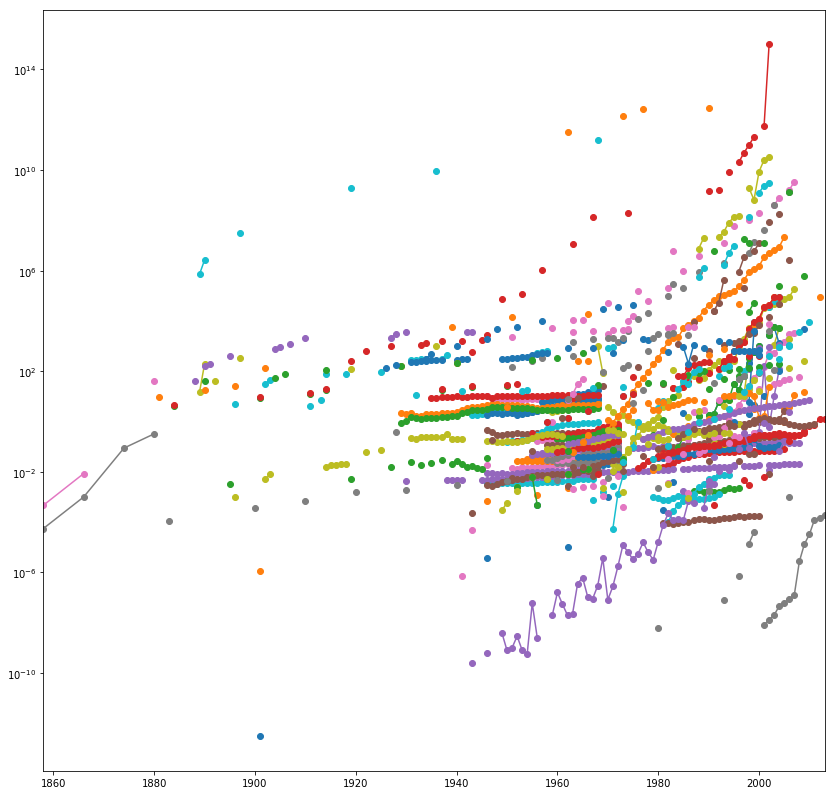

In [77]:
time_series.plot(legend=False, figsize=(14,14), marker='o')
yscale('log')

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


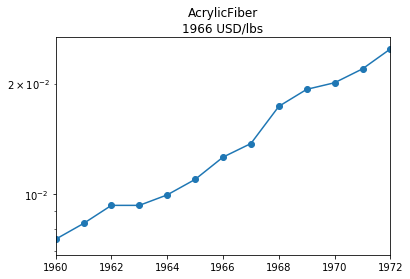

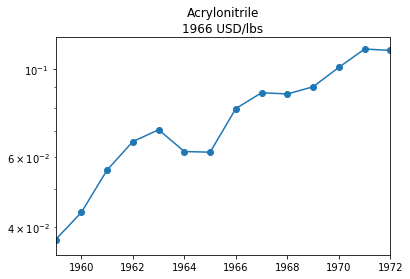

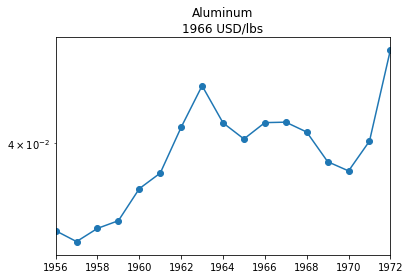

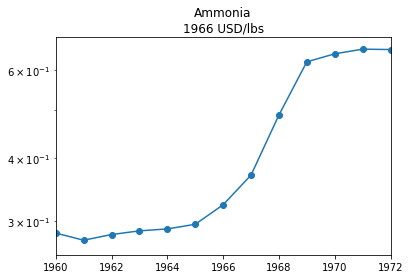

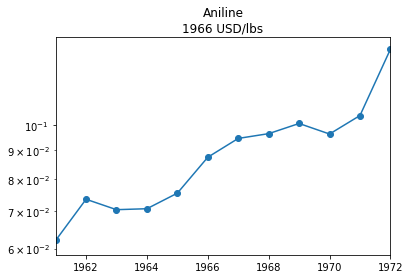

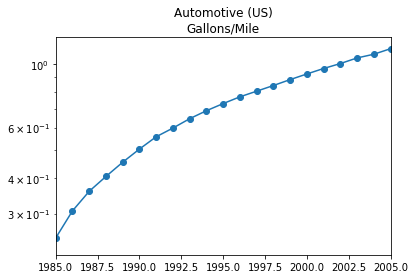

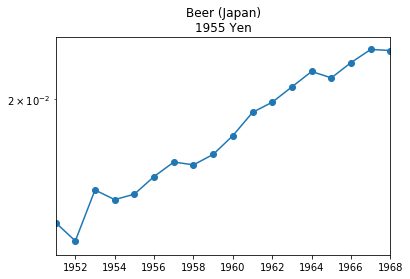

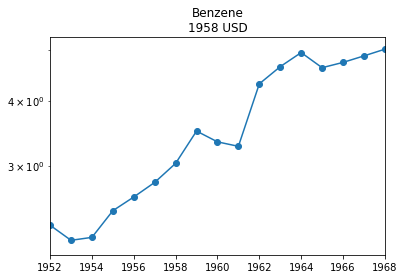

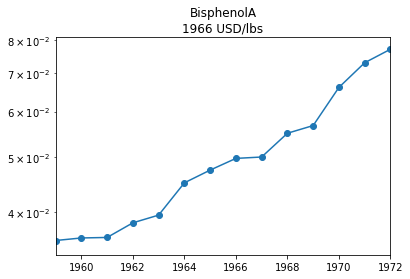

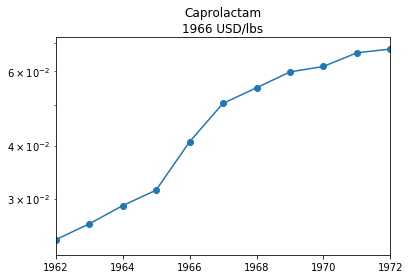

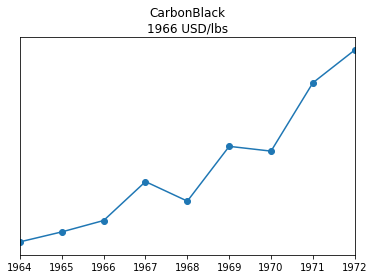

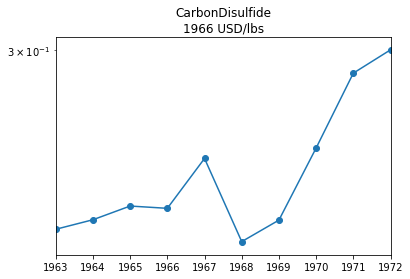

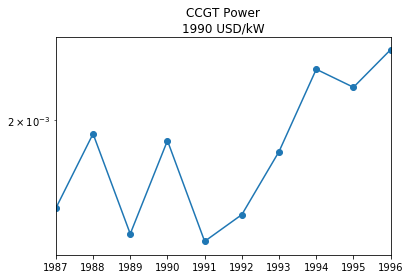

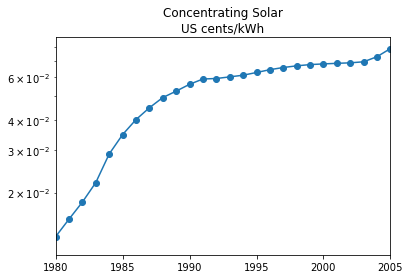

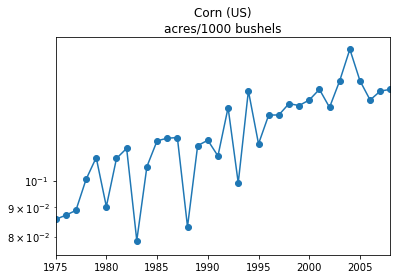

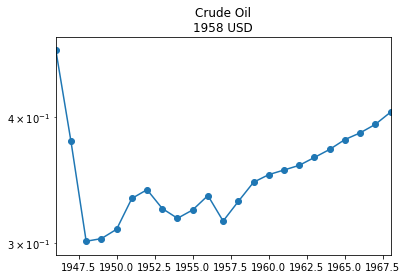

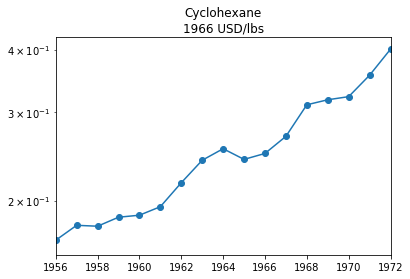

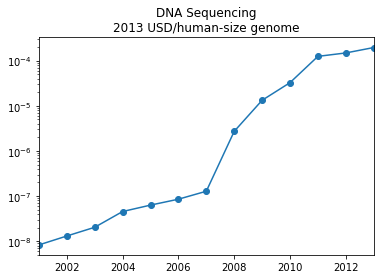

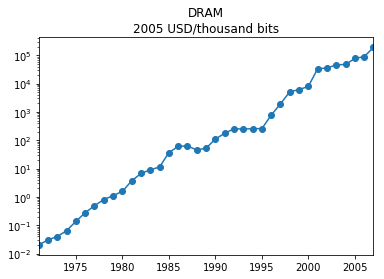

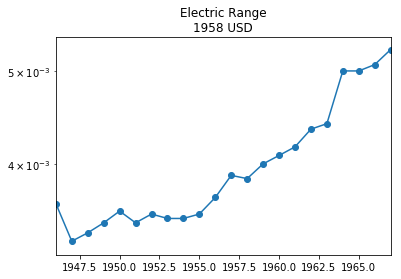

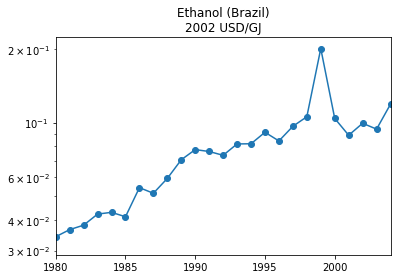

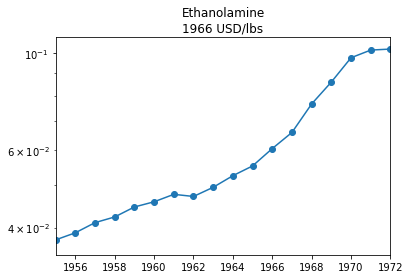

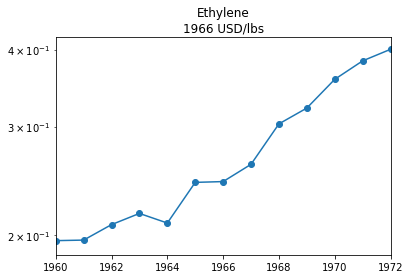

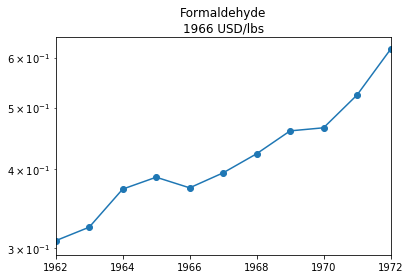

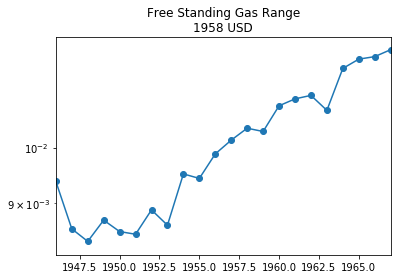

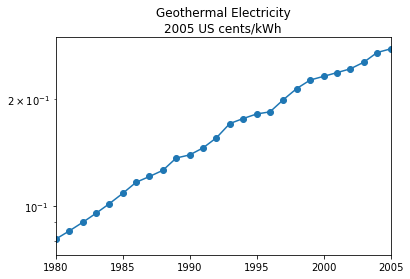

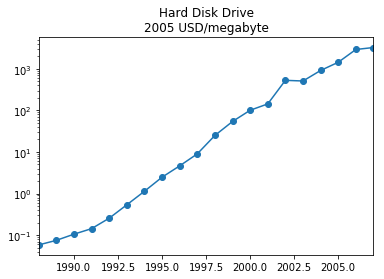

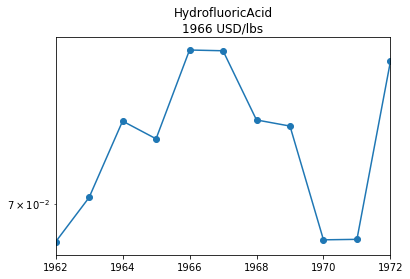

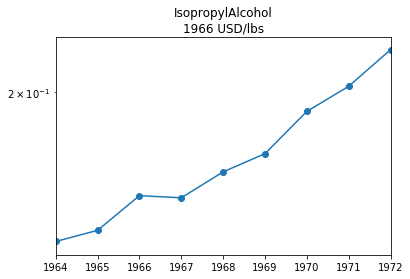

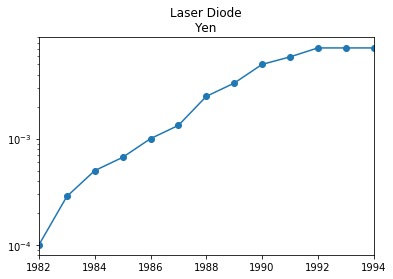

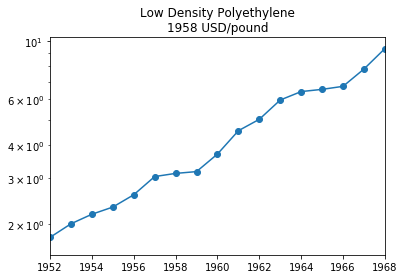

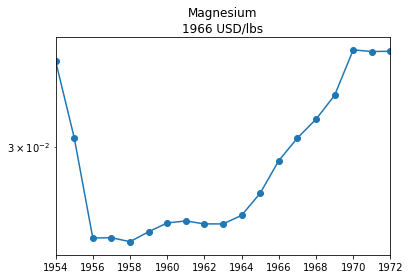

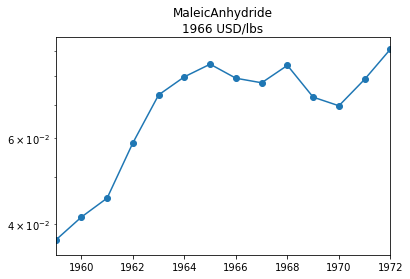

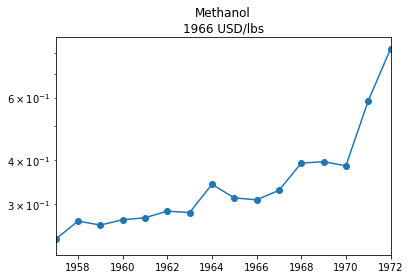

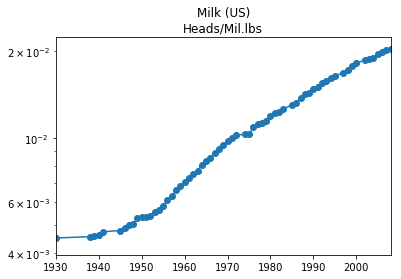

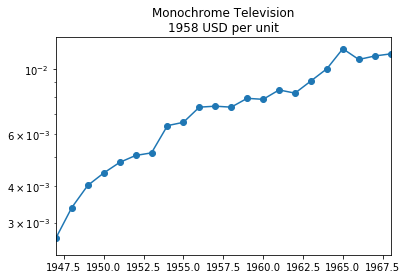

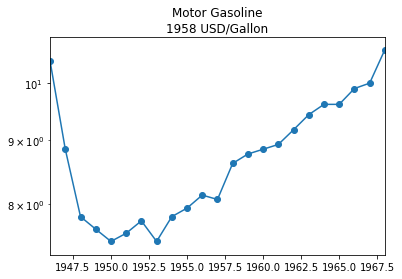

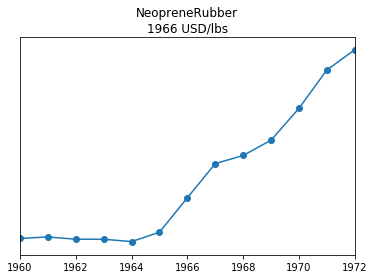

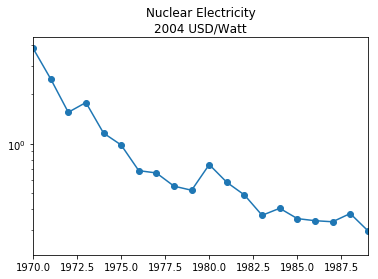

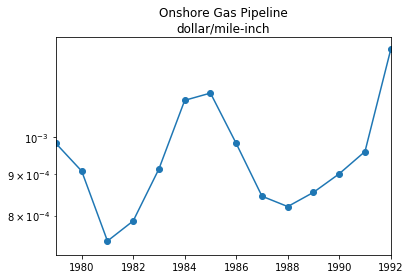

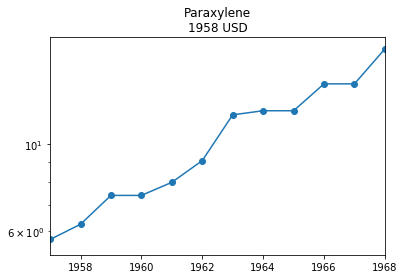

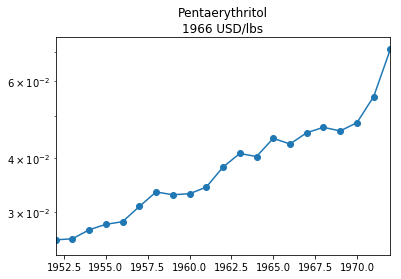

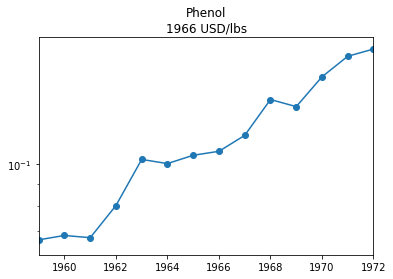

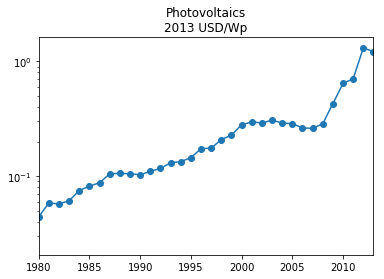

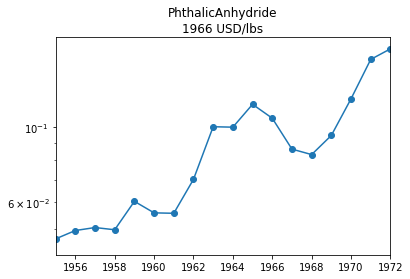

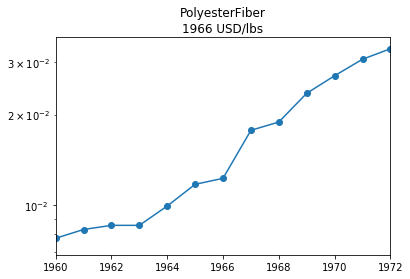

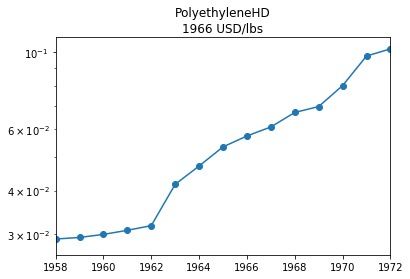

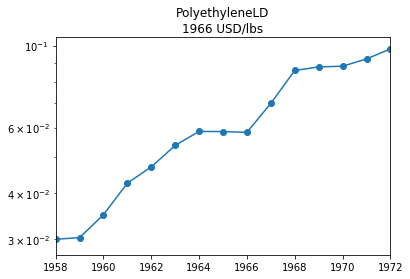

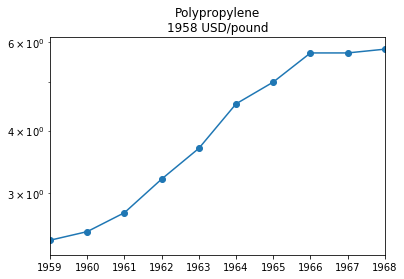

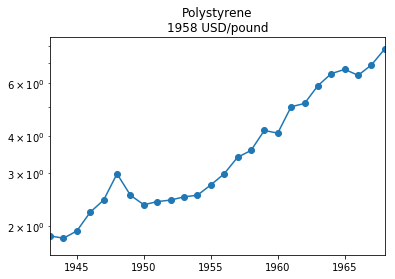

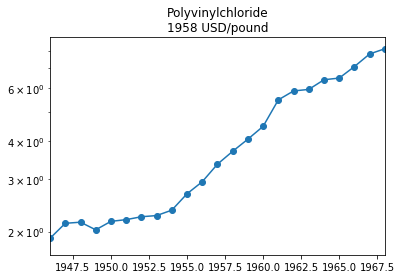

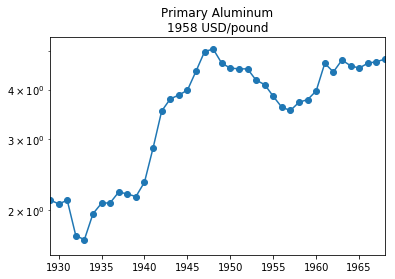

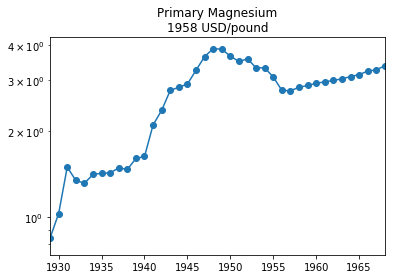

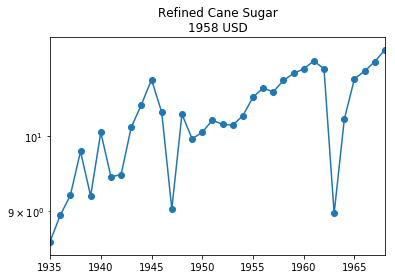

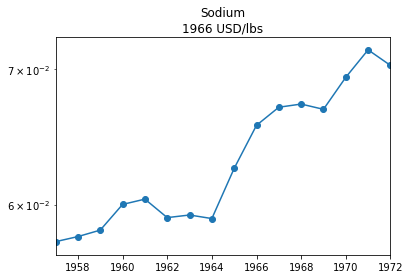

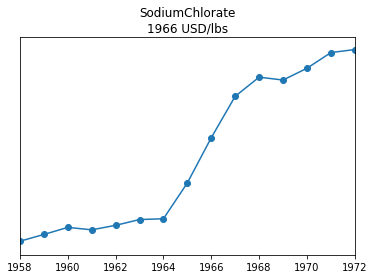

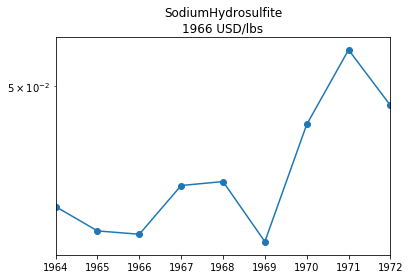

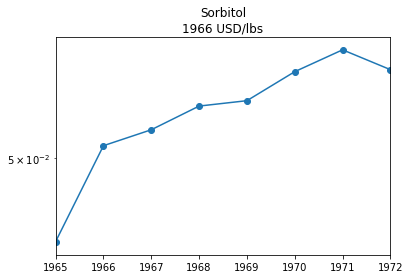

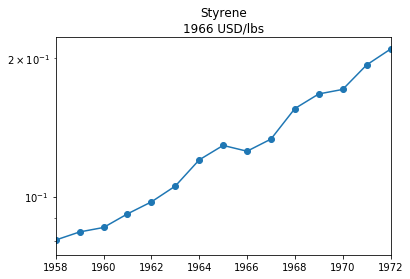

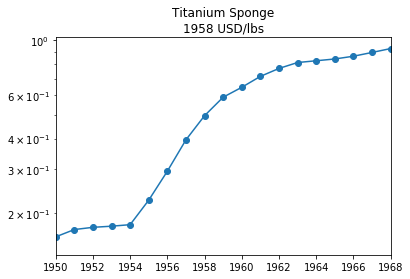

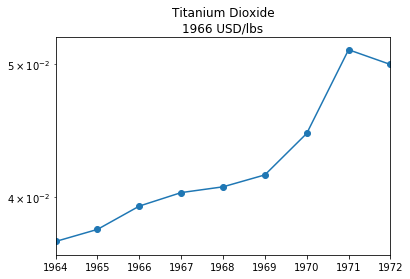

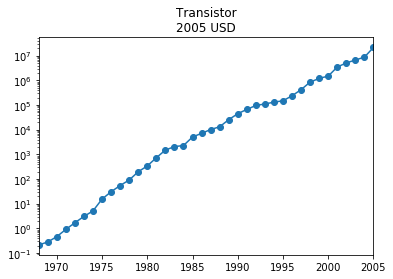

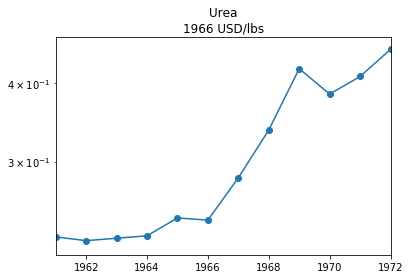

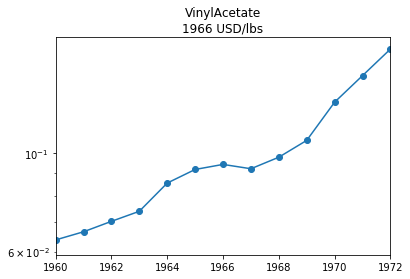

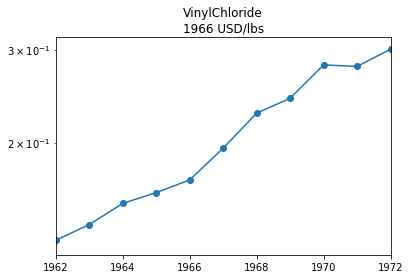

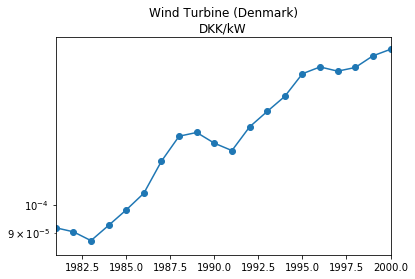

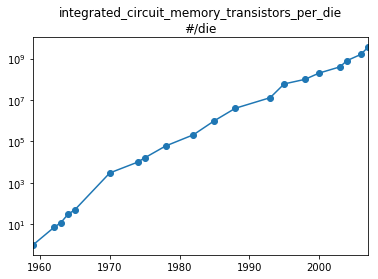

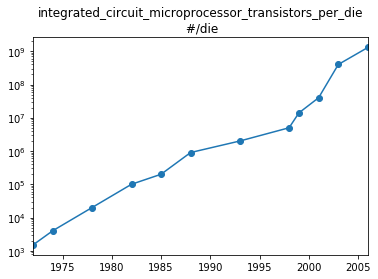

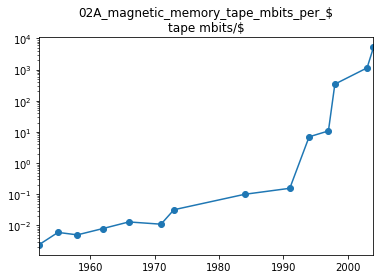

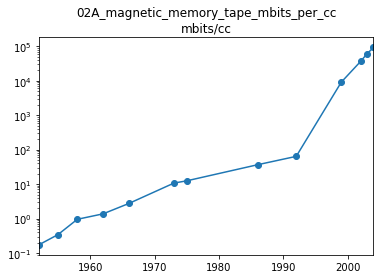

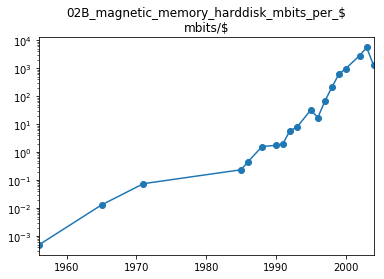

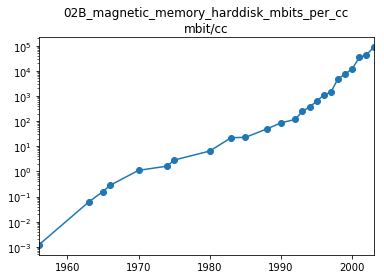

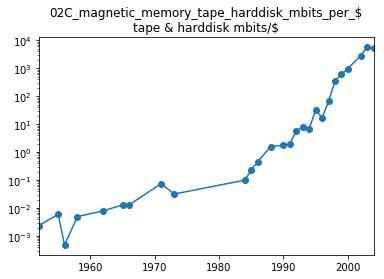

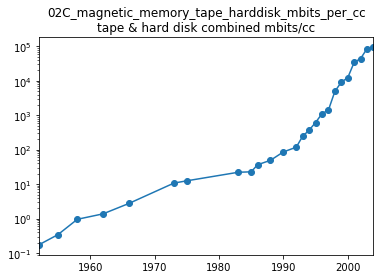

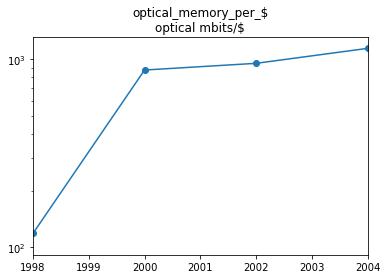

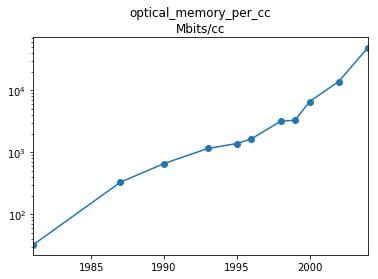

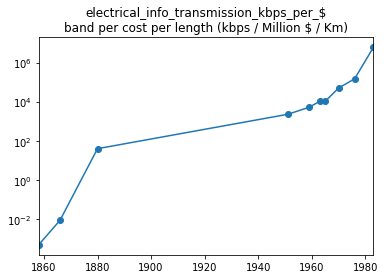

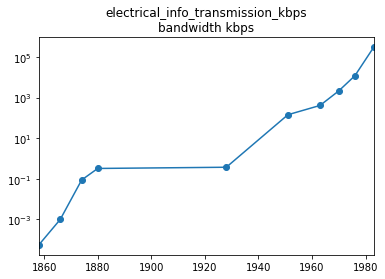

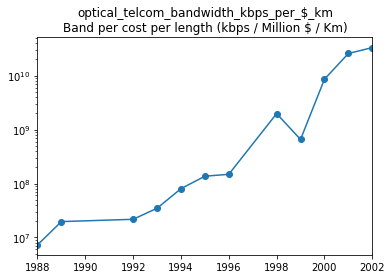

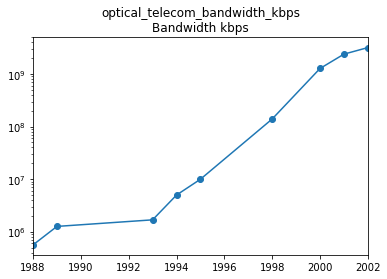

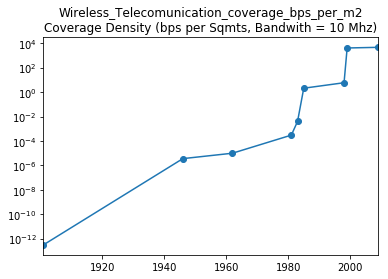

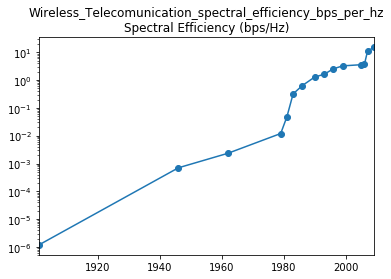

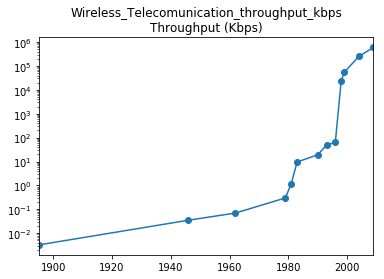

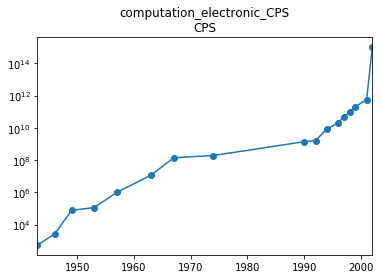

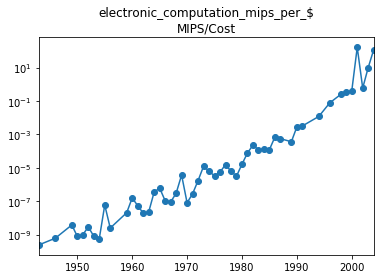

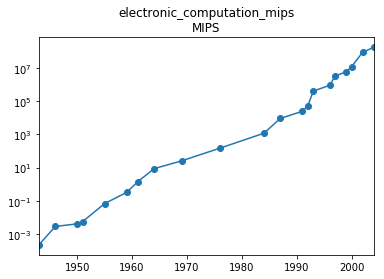

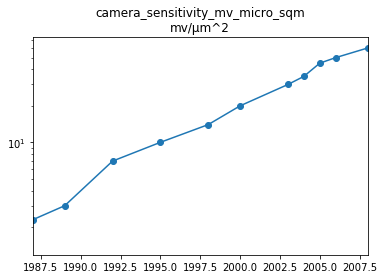

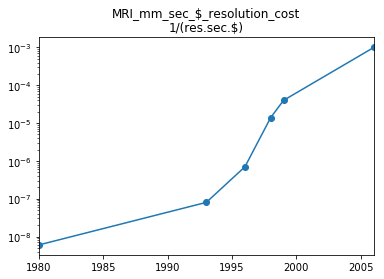

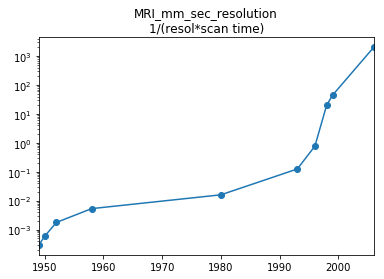

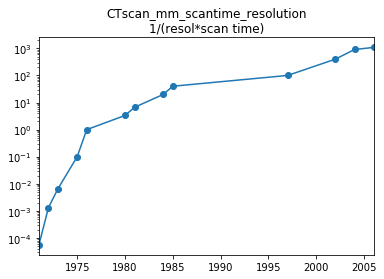

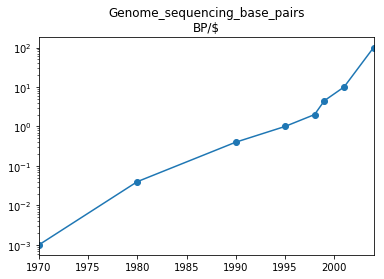

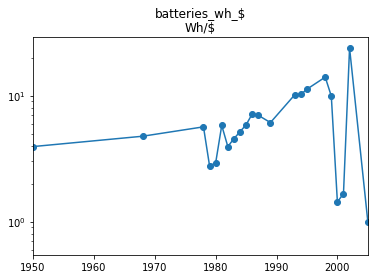

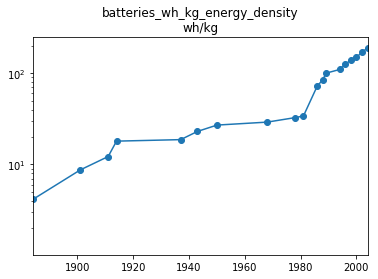

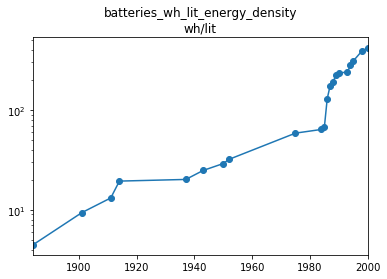

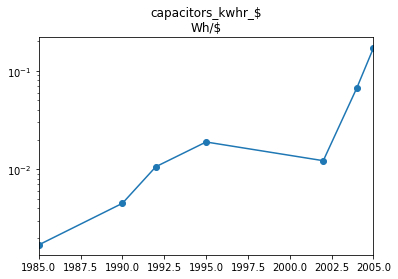

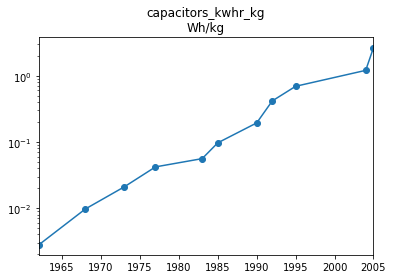

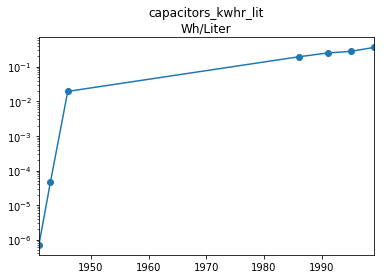

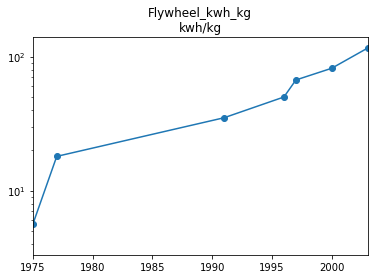

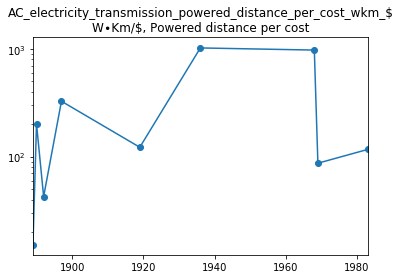

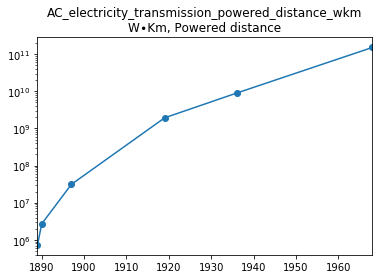

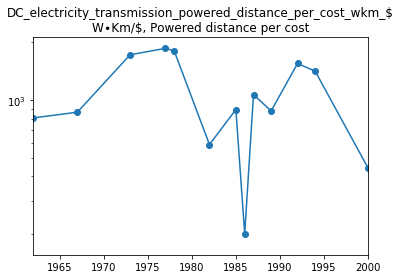

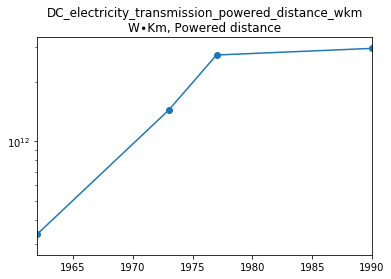

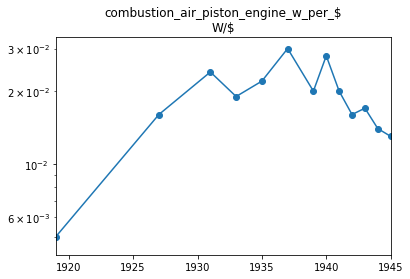

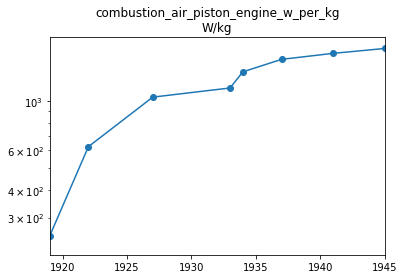

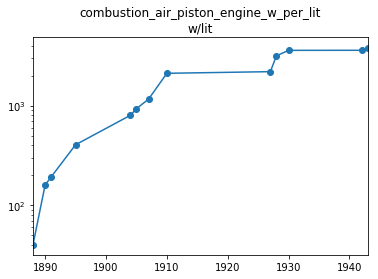

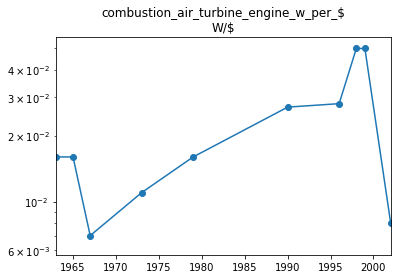

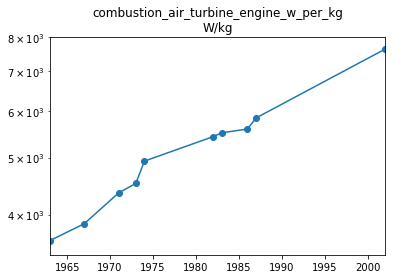

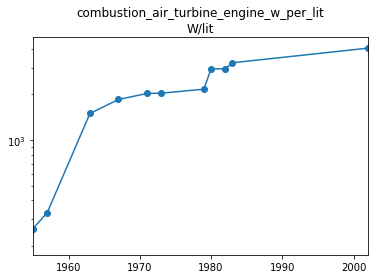

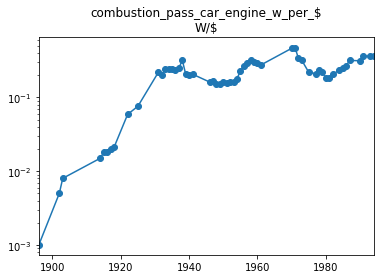

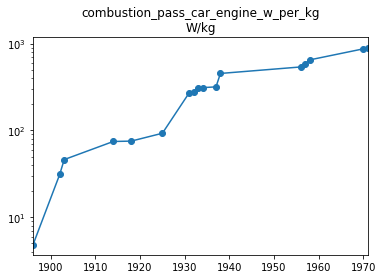

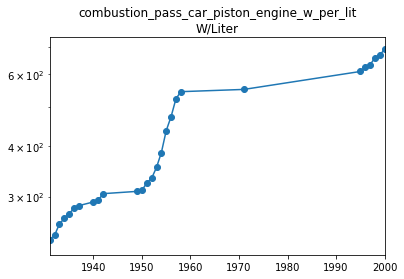

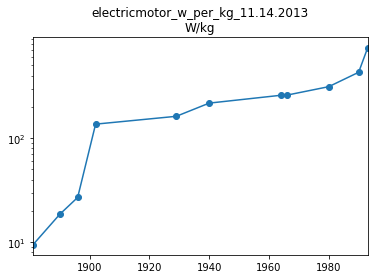

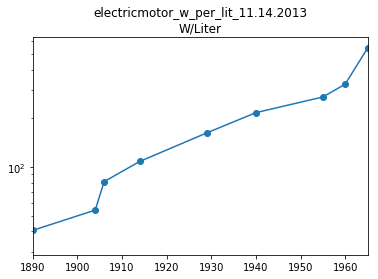

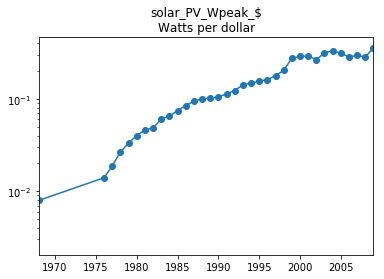

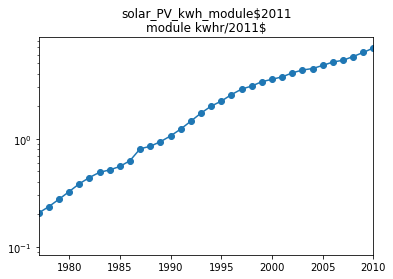

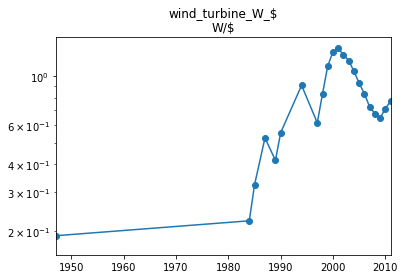

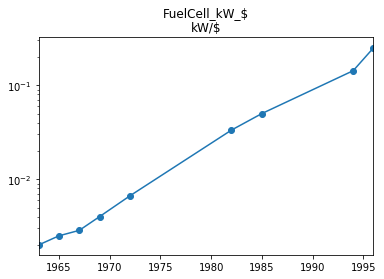

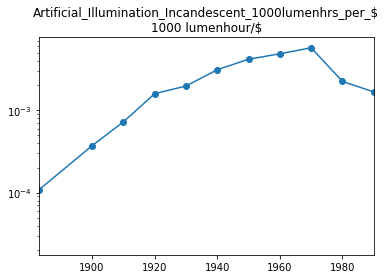

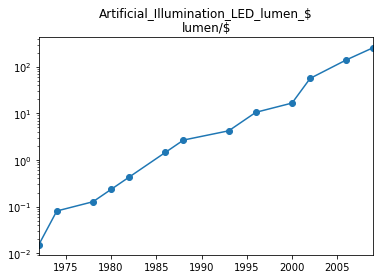

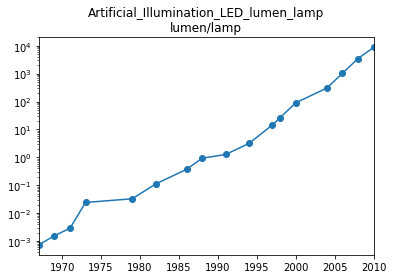

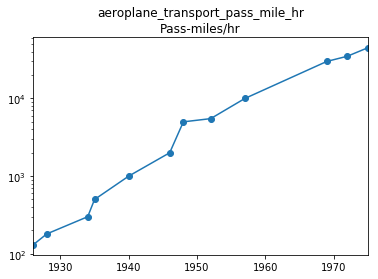

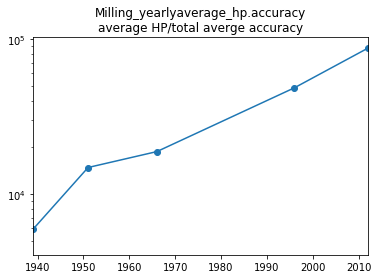

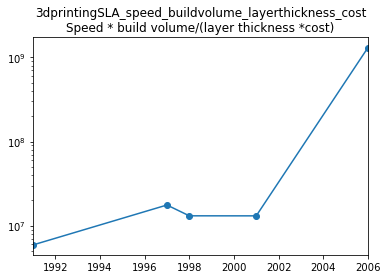

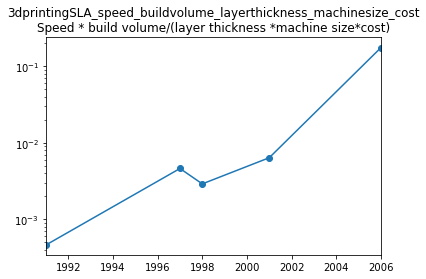

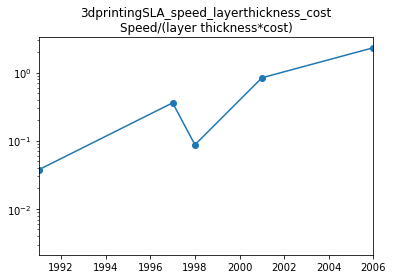

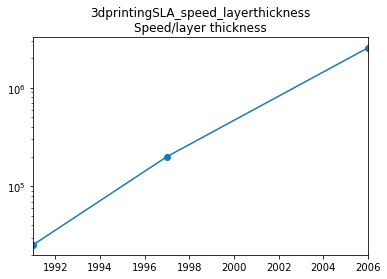

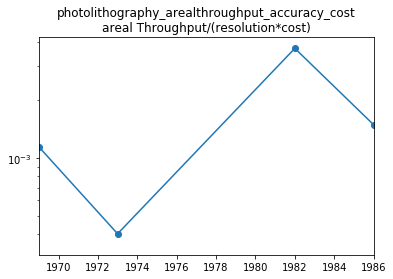

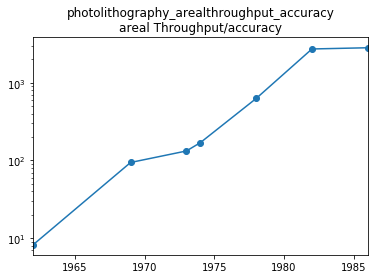

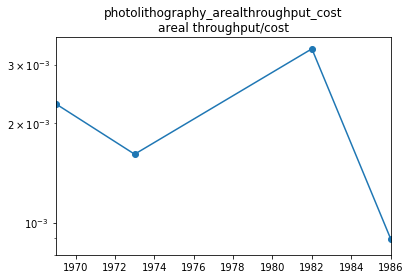

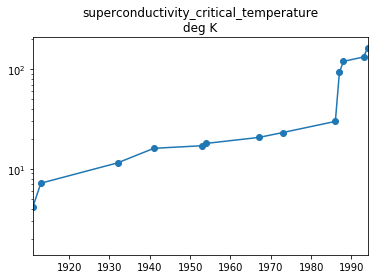

In [79]:
for c in time_series.columns:
    figure()
    time_series[c].dropna().plot(legend=False, marker='o')
    yscale('log')
    title('%s\n%s'%(c, time_series_metadata.ix[c, 'Units']))

In [93]:
time_series_metadata['Type'].value_counts()

Price                       86
Performance                 35
Price_Questionable           6
Performance_Questionable     4
Name: Type, dtype: int64

In [95]:
time_series_metadata.loc[time_series_metadata['Stop']>1985,'Type'].value_counts()

Price                       34
Performance                 32
Price_Questionable           4
Performance_Questionable     2
Name: Type, dtype: int64

In [130]:
valid_technologies = time_series_metadata[(time_series_metadata['Type']=='Price')+(time_series_metadata['Type']=='Performance')].index.values
time_series[valid_technologies].loc[1985:].notnull().sum().sum()
### All time points after 1985

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


668

In [131]:
valid_technologies = time_series_metadata[time_series_metadata['Domain'].notnull()*((time_series_metadata['Type']=='Price')+(time_series_metadata['Type']=='Performance'))].index.values
time_series[valid_technologies].loc[1985:].notnull().sum().sum()
### All time points after 1985 from time series that have associated patent data

/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))
/home/jeffrey_alstott/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


527

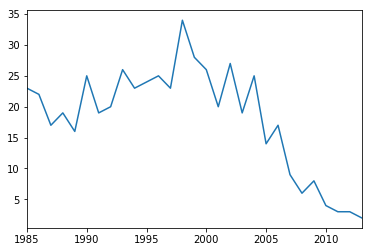

In [132]:
time_series[valid_technologies].loc[1985:].notnull().sum(axis=1).plot()

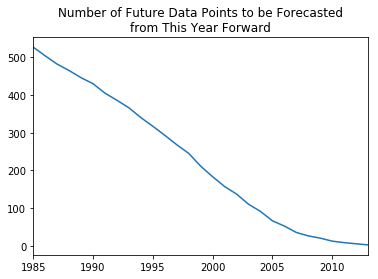

In [133]:
time_series[valid_technologies].loc[1985:].notnull().sum(axis=1).iloc[::-1].cumsum().loc[::-1].plot()
title("Number of Future Data Points to be Forecasted\nfrom This Year Forward")

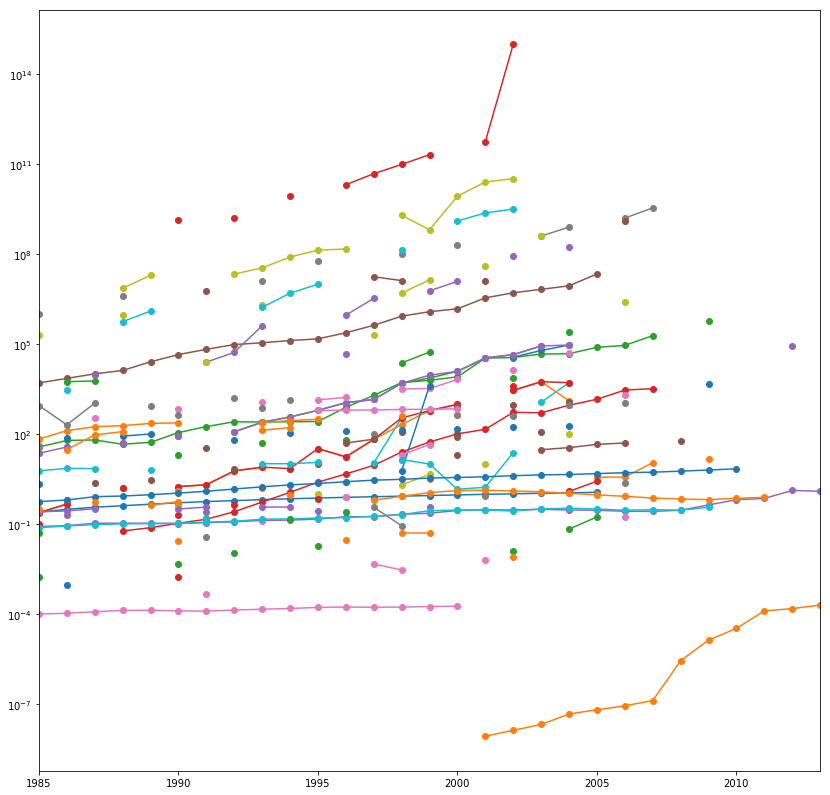

In [136]:
time_series[valid_technologies].loc[1985:].plot(marker='o', figsize=(14,14), legend=False)
yscale('log')